In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/final_project/dataset_final/masks_patches_filtered_train.zip'
!unzip '/content/drive/MyDrive/final_project/dataset_final/images_patches_filtered_train.zip'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

In [ ]:
root = '/content/content'
img_list = sorted(os.listdir(root + '/images_patches/'))
mask_list = sorted(os.listdir(root + '/masks_patches/'))
df = pd.DataFrame()
cp = mask_list.copy()
df['slide_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['region_no'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_x'] = [ s[:s.find('_')] for s in cp]
cp = [ s[s.find('_')+1:] for s in cp]
df['patch_position_y'] = [ s[:s.find('.')] for s in cp]
df['img_fullpath'] = [root+ "/images_patches/" + s for s in img_list]
df['mask_fullpath'] = [root+ "/masks_patches/" + s for s in mask_list]
w_list = list()
b_list = list()
w_rate_list = list()
for m_path in df['mask_fullpath']:
 m = cv2.imread(m_path,0)
 w = cv2.countNonZero(m)
 b = m.shape[0]*m.shape[1] - w
 w_rate = w / (m.shape[0]*m.shape[1])
 w_list.append(w)
 b_list.append(b)
 w_rate_list.append(w_rate)

df['whitepixels'] = w_list
df['blackpixels'] = b_list
df['whitepixels_rate'] = w_rate_list
df["epidermis_percentage"] = (df["whitepixels_rate"]*100).apply(np.ceil)



df_filtered = df.copy()
upper_th = df_filtered['epidermis_percentage']>=50
lower_th = df_filtered['epidermis_percentage']<=100

df_filtered = df_filtered[lower_th]
df_filtered = df_filtered[upper_th]
df_filtered.index = range(len(df_filtered))

df2 = df.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df)
df_filtered2 = df_filtered.groupby(by=["epidermis_percentage"]).count().reset_index()['slide_no']*100/len(df_filtered)

df_filtered

,slide_no,region_no,patch_position_x,patch_position_y,img_fullpath,mask_fullpath,whitepixels,blackpixels,whitepixels_rate,epidermis_percentage
0,01,1,0,4,/content/content/images_patches/01_1_0_4.png,/content/content/masks_patches/01_1_0_4.png,148932,113212,0.568130,57.0
1,01,1,2,10,/content/content/images_patches/01_1_2_10.png,/content/content/masks_patches/01_1_2_10.png,177901,84243,0.678638,68.0
2,01,1,2,8,/content/content/images_patches/01_1_2_8.png,/content/content/masks_patches/01_1_2_8.png,147956,114188,0.564407,57.0
3,01,1,2,9,/content/content/images_patches/01_1_2_9.png,/content/content/masks_patches/01_1_2_9.png,172392,89752,0.657623,66.0
4,01,1,7,14,/content/content/images_patches/01_1_7_14.png,/content/content/masks_patches/01_1_7_14.png,141564,120580,0.540024,55.0
...,...,...,...,...,...,...,...,...,...,...
3166,50,0,5,2,/content/content/images_patches/50_0_5_2.png,/content/content/masks_patches/50_0_5_2.png,226110,36034,0.862541,87.0
3167,50,0,60,18,/content/content/images_patches/50_0_60_18.png,/content/content/masks_patches/50_0_60_18.png,129689,132455,0.494724,50.0
3168,50,0,6,1,/content/content/images_patches/50_0_6_1.png,/content/content/masks_patches/50_0_6_1.png,160271,101873,0.611385,62.0
3169,50,0,8,0,/content/content/images_patches/50_0_8_0.png,/content/content/masks_patches/50_0_8_0.png,165774,96370,0.632378,64.0


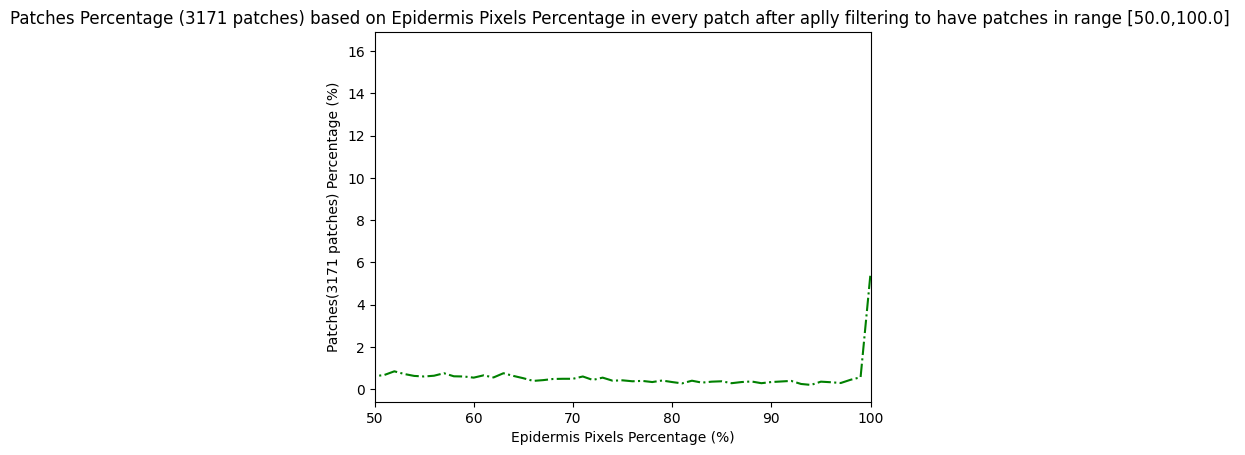

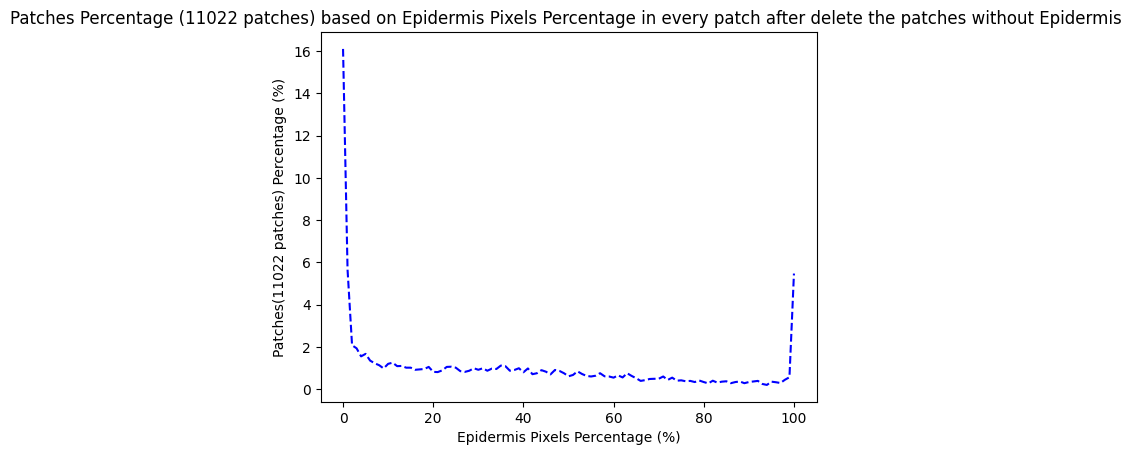

In [ ]:
(epi_min,epi_max) = df_filtered['epidermis_percentage'].min(),df_filtered['epidermis_percentage'].max()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df_filtered))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'green',linestyle='-.',ax = ax)
plt.title(f'Patches Percentage ({len(df_filtered)} patches) based on Epidermis Pixels Percentage in every patch after aplly filtering to have patches in range [{epi_min},{epi_max}] ')
ax.set_xlim(epi_min, epi_max)
plt.show()
ax = plt.gca()
ax.set_xlabel("Epidermis Pixels Percentage (%)")
ax.set_ylabel('Patches('+str(len(df))+' patches) Percentage (%)')
df2.plot(kind = 'line', x = 'epidermis_percentage', y = 'slide_no', color = 'blue',linestyle='--',ax = ax)
plt.title('Patches Percentage ('+str(len(df))+' patches) based on Epidermis Pixels Percentage in every patch after delete the patches without Epidermis ')
plt.show()

In [ ]:
def image_generator(dataf, batch_size = 64):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(dataf.index.values, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = [] 

    for idx in batch:

        #get the masks. Note that masks are png files 

        mask = Image.open(dataf.iloc[idx]['mask_fullpath'])

        mask = np.array(mask)

        #preprocess the mask 
        mask[mask == 255] = 1 
        mask[mask == 0 ] = 0
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(dataf.iloc[idx]['img_fullpath'])
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [ ]:
# split data to train and test groups
from sklearn.model_selection import train_test_split

batch_size = 128

train_df, val_df = train_test_split(df_filtered, test_size=0.2)
train_df.index = range(len(train_df))
val_df.index = range(len(val_df))


train_generator = image_generator(train_df, batch_size = batch_size)
val_generator  = image_generator(val_df, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

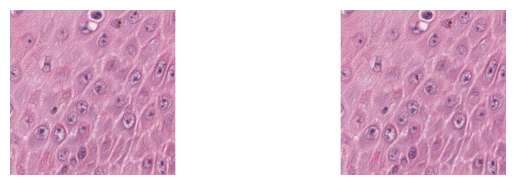

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def unet(sz = (512, 512, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 2
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('epoch=',self.i,'loss=',np.round(logs.get('loss'),4),'val_loss=',np.round(logs.get('val_loss'),4),'mean_iou=',np.round(logs.get('mean_iou'),4),'val_mean_iou=',np.round(logs.get('val_mean_iou'),4))
        
        #choose a random test image and preprocess
        j = np.random.choice(val_df.index.values)
        raw = Image.open(val_df.iloc[j]['img_fullpath'])
        ground_truth = Image.open(val_df.iloc[j]['mask_fullpath'])
        raw = np.array(raw.resize((512, 512)))/255.
        ground_truth = np.array(ground_truth.resize((512, 512)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        pred_msk  = pred.squeeze()
        pred_msk = np.stack((pred_msk,)*3, axis=-1)
        
        pred_msk[pred_msk >= 0.5] = 1 
        pred_msk[pred_msk < 0.5] = 0 
        
        ground_truth = np.stack((ground_truth,)*3, axis=-1)
        #show the mask and the segmented image 
        
        combined = np.concatenate([raw, pred_msk, raw* pred_msk,raw*ground_truth], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [ ]:
train_steps = len(train_df) //batch_size
val_steps = len(val_df) //batch_size
history = model.fit_generator(train_generator, 
                    epochs = 60, steps_per_epoch = train_steps,validation_data = val_generator, validation_steps = val_steps,
                    callbacks = build_callbacks(), verbose = 0)

In [ ]:
model.save('unet_filtered_50.h5');

In [ ]:
import json
with open("history_unet_filtered_50.json", "w") as outfile:
    json.dump(history.history, outfile)

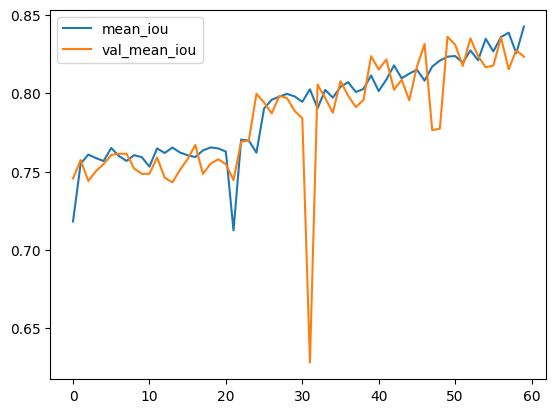

In [ ]:
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.legend(['mean_iou', 'val_mean_iou'])
plt.show()

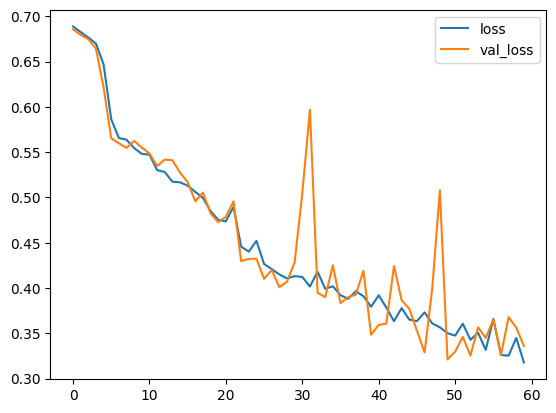

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()